# Discretization of the map for Convex polygonal obstacles
This document will solve a discretization problem in which the obstacles are convex polygons. To do this, we will first build a quantum circuit that checks if a point belongs to a set of points. Once this circuit is built, we can use Grover's algorithm to solve our problem.

Our objective is to calculate points that belong to the polygon that we have drawn. To do this we need a set of functions that allow us to build the quantum circuit that solves the problem.

In [ ]:
!pip3 install pennylane > out

Let us load the libraries

In [ ]:
## Libraries
import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt
import time
%config InlineBackend.figure_format = 'retina'

In [ ]:
# Functions to display the graphics
# Pre-condition:
# - 'plt' from matplotlib must be imported
# - 'nCoordX' and 'nCoordY' should be defined and represent the dimensions of the grid

# Post-condition:
# - 'draw_board' function creates a grid based on 'nCoordX' and 'nCoordY' values
# - 'draw_points' function plots the points from 'list_points' on the grid


# Function to draw the grid
def draw_board():
    # Define the limits for the x and y coordinates
    x_lim = [-1, 2**nCoordX]
    y_lim = [-1, 2**nCoordY]

    # Set the limits for the plot
    plt.xlim(x_lim[0], x_lim[1])
    plt.ylim(y_lim[0], y_lim[1])

    # Set labels for the x and y axes
    plt.xlabel('x coordinate')
    plt.ylabel('y coordinate')

    # Number of rows in the grid
    nRows = 2**nCoordY

    # Draw horizontal and vertical lines to create the grid
    for i in range(nRows):
        y_current = [i, i]
        x_current = [0, 2**nCoordX]
        plt.plot([0, 2**nCoordX - 1], [i, i], color="black", linewidth=0.3)
        plt.plot([i, i], [0, 2**nCoordY - 1], color="black", linewidth=0.3)

# Function to draw points on the grid
def draw_points(list_points):
    # Number of points to draw
    nPoints = len(list_points)

    # Draw each point in the list as a red dot
    for i in range(nPoints):
        plt.scatter(list_points[i][0], list_points[i][1], color="red")



In [ ]:
# Pre-condition:
# - 'plt' from matplotlib must be imported
# - 'np' from numpy should be imported for array operations

# Post-condition:
# - 'initialize' function sets up the polygon with the given vertices and calculates its vectors
# - 'draw' function plots the polygon on a matplotlib plot with the specified color


# Polygon Class
class pcPolygon():
    # Constructor to initialize the polygon class
    def __init__(self):
        self.vertex_list = list()  # List to store vertices of the polygon
        self.vector_list = list()  # List to store vectors representing the sides of the polygon
        self.nVertex = 0  # Number of vertices

    # Initialize the polygon with a list of vertices
    def initialize(self, vertex_list):
        self.vertex_list = vertex_list  # Assign the list of vertices
        self.nVertex = len(vertex_list)  # Count the number of vertices

        # Generate the list of vectors (sides) of the polygon
        for i in range(1, self.nVertex):
            self.vector_list.append(vertex_list[i] - vertex_list[i - 1])
        # Add the vector from the last vertex to the first
        self.vector_list.append(vertex_list[0] - vertex_list[-1])

    # Function to draw the polygon
    def draw(self, color="blue"):
        # Draw each side of the polygon
        for i in range(self.nVertex):
            plt.plot([self.vertex_list[i-1][0], self.vertex_list[i][0]],
                     [self.vertex_list[i-1][1], self.vertex_list[i][1]],
                     color=color)



In [ ]:
## Limites del problema
nCoordX = 2
nCoordY = 2



### 2 Quantum functions
The following set of quantum functions solves part of the final problem.

In [ ]:
# Pre-condition:
# - 'qml' from PennyLane must be imported for quantum operations
# - 'np' from numpy should be imported for array operations

# Post-condition:
# - 'binary_to_integer' function converts a binary array (list of 0s and 1s) to an integer
# - 'apply_hadamard' function applies the Hadamard gate to each wire (qubit) in the provided list


# Auxiliary Functions

# Converts a binary array to its corresponding integer value
def binary_to_integer(vOutput):
    # Generate an array of powers of 2, in reverse order
    vPows = 2**np.array(range(len(vOutput)))
    vPows = vPows[::-1]

    # Perform dot product to convert binary to integer
    return np.dot(vOutput, vPows)

# Applies the Hadamard gate to a list of qubits
def apply_hadamard(wires_h):
    # Loop through the list of wires and apply the Hadamard gate to each
    for i in wires_h:
        qml.Hadamard(wires=i)


In [ ]:
# Pre-condition:
# - 'qml' from PennyLane must be imported for quantum operations

# Post-condition:
# - 'opposite' function converts the quantum state representing a positive integer to its negative counterpart
# - 'opposite_inv' function reverts the state back from a negative integer representation to a positive one



# Integer Arithmetic Functions

# Converts the state of qubits from representing a positive integer to a negative integer
def opposite(wires_x):
    # Determine the number of qubits
    n = len(wires_x)

    # Apply Pauli-X gate to each qubit, flipping its state
    for i in range(n):
        qml.PauliX(wires=wires_x[i])

    # Apply Quantum Fourier Transform (QFT) to the wires
    qml.QFT(wires=wires_x)

    # Add 1 to the value represented by qubits
    sum_k(1, wires_x)

    # Apply the inverse of Quantum Fourier Transform (QFT)
    qml.adjoint(qml.QFT)(wires=wires_x)

# Converts the state of qubits from representing a negative integer back to a positive integer
def opposite_inv(wires_x):
    # Apply the inverse of the 'opposite' function
    qml.adjoint(opposite)(wires_x)



In [ ]:
# Pre-condition:
# - 'qml' from PennyLane must be imported for quantum operations

# Post-condition:
# - 'sum_k' applies a rotation gate to each qubit in 'wires' based on a scalar 'k'
# - 'multiplicacion_escalar' multiplies a quantum state represented by 'wires_x' with scalar 'k', storing the result in 'wires_res'
# - 'compute_substraction' computes the subtraction of a point 'pnt' from quantum states represented by 'wires_x' and 'wires_y'


# General Arithmetic Functions

# Applies a rotation gate based on a scalar value 'k' to a series of qubits
def sum_k(k, wires):
    # Apply a rotation gate to each qubit based on 'k' and its position in the wires
    for j in range(len(wires)):
        qml.RZ(k * np.pi / (2**j), wires=wires[j])

# Multiplies a quantum state represented by 'wires_x' with a scalar 'k' and stores the result in 'wires_res'
def multiplicacion_escalar(k, wires_x, wires_res):
    n = len(wires_x)

    # Check if there are enough qubits in the result wires
    if len(wires_res) < (2*n):
        print("Not enough result qubits")
        return

    # Compute the multiplication result
    for i in range(n):
        value = k * 2**(n - i - 1)
        qml.ctrl(sum_k, control=wires_x[i])(value, wires_res)

# Computes the subtraction of a point 'pnt' from quantum states represented by 'wires_x' and 'wires_y'
def compute_substraction(pnt, wires_x, wires_y):
    # Apply Quantum Fourier Transform (QFT) and subtraction on 'wires_x'
    qml.QFT(wires=wires_x)
    sum_k(-pnt[0], wires_x)
    qml.adjoint(qml.QFT)(wires_x)

    # Apply Quantum Fourier Transform (QFT) and subtraction on 'wires_y'
    qml.QFT(wires=wires_y)
    sum_k(-pnt[1], wires_y)
    qml.adjoint(qml.QFT)(wires_y)


In [ ]:
# Pre-condition:
# - 'qml' from PennyLane and necessary arithmetic functions must be imported
# - 'vector' should be a 2-element array representing a vector in 2D
# - 'wires_x' and 'wires_y' are the quantum wires representing two vectors
# - 'wires_mult' and 'wires_aux' are ancillary wires used in the computation

# Post-condition:
# - Computes the cross product of two vectors represented by 'wires_x' and 'wires_y'
# - The result of the cross product is stored in 'wires_mult'
# - Uses ancillary qubits 'wires_aux' for intermediate computations


# Function to compute the cross product of two vectors
def cross_product(vector, wires_x, wires_y, wires_mult, wires_aux):
    # Check if there is at least one ancillary qubit
    if len(wires_aux) < 1:
        print("Not enough ancillary qubits to compute the cross product")
        return

    # Prepare the wires for multiplication result
    qml.QFT(wires=wires_mult)

    # Process for the x-component of the cross product
    qml.CNOT(wires=[wires_x[0], wires_aux[0]])
    qml.ctrl(opposite_inv, control=wires_aux[0])(wires_x)  # Convert negative to positive
    multiplicacion_escalar(vector[1], wires_x, wires_mult)  # Multiply and store result
    qml.ctrl(multiplicacion_escalar, control=wires_aux[0])(-2*vector[1], wires_x, wires_mult)
    qml.ctrl(opposite, control=wires_aux[0])(wires_x)  # Convert back to original sign
    qml.CNOT(wires=[wires_x[0], wires_aux[0]])

    # Process for the y-component of the cross product
    qml.CNOT(wires=[wires_y[0], wires_aux[0]])
    qml.ctrl(opposite_inv, control=wires_aux[0])(wires_y)
    multiplicacion_escalar(-vector[0], wires_y, wires_mult)
    qml.ctrl(multiplicacion_escalar, control=wires_aux[0])(2*vector[0], wires_y, wires_mult)
    qml.ctrl(opposite, control=wires_aux[0])(wires_y)
    qml.CNOT(wires=[wires_y[0], wires_aux[0]])

    # Finalize the computation and restore the basis
    sum_k(-1, wires_mult)
    qml.adjoint(qml.QFT)(wires=wires_mult)



The ***compare*** function checks which side of a line a given point is located on.

In [ ]:
# Pre-condition:
# - 'qml' from PennyLane and necessary arithmetic functions must be imported
# - 'pnt' and 'vector' should be arrays representing a point and a vector in 2D
# - 'wires_x', 'wires_y', and 'wire_res' are quantum wires representing x, y coordinates, and the result
# - 'wires_aux_original' are ancillary wires used in the computation

# Post-condition:
# - Compares a given point 'pnt' with a vector 'vector' by computing their cross product
# - The result of the comparison is stored in 'wire_res'
# - Uses 'wires_x', 'wires_y', and ancillary qubits 'wires_aux_original' for computation
# - Restores the quantum state to its initial form after computation


# Function to compare a point with a vector using cross product
def compare(pnt, vector, wires_x, wires_y, wires_aux_original, wire_res):
    # Check if the number of x and y qubits is the same
    if not (len(wires_x) == len(wires_y)):
        print("The number of x qubits must be the same as y qubits")
        return

    # Check if there are enough ancillary qubits
    if len(wires_aux_original) < (len(wires_x) + len(wires_y) + 2):
        print("Not enough ancillary qubits")
        return

    # Set the wires for auxiliary and multiplication
    wires_aux = [wires_aux_original[0]]
    wires_mult = wires_aux_original[1:]

    # Compute the subtraction (x,y) - (p1, p2)
    compute_substraction(pnt, wires_x, wires_y)

    # Compute the cross product between the vector and the subtracted point
    cross_product(vector, wires_x, wires_y, wires_mult, wires_aux)

    # Store the result in the result wire
    qml.CNOT(wires=[wires_mult[0], wire_res[0]])
    qml.PauliX(wires=wire_res[0])

    # Restore the circuit to its initial state
    qml.adjoint(cross_product)(vector, wires_x, wires_y, wires_mult, wires_aux)
    qml.adjoint(compute_substraction)(pnt, wires_x, wires_y)



## Function *is_in_polygon*
This function checks whether a point belongs to the interior of a polygon or not. From this function we can build the oracle that will allow us to implement Grover's algorithm.

In [ ]:
# Pre-condition:
# - 'qml' from PennyLane and necessary arithmetic functions must be imported
# - 'polygon' should be an instance of a polygon class with vertex and vector lists
# - 'wires_x' and 'wires_y' are quantum wires representing x, y coordinates
# - 'wires_aux' are ancillary wires used in the computation
# - 'wires_sum' are quantum wires used for summation

# Post-condition:
# - Determines if a quantum state representing a point is inside the polygon defined by 'polygon'
# - Uses 'wires_x' and 'wires_y' for point coordinates and 'wires_aux' for ancillary computations
# - The summation of results across polygon edges is calculated using 'wires_sum'
# - Restores the quantum state to its initial configuration after computation

# Function to determine if a point is inside a polygon
def is_in_polygon(polygon, wires_x, wires_y, wires_aux, wires_sum):
    nVertex = polygon.nVertex  # Number of vertices in the polygon
    m = int(np.ceil(np.log2(nVertex)))  # Calculate the number of qubits needed for summation

    # Check if there are enough sum qubits
    if len(wires_sum) < m:
        print("Not enough sum qubits")
        return

    # Check if there are enough ancillary qubits
    if len(wires_aux) < (2*n + 3):
        print("Not enough ancillary qubits")
        return

    # Set wires for edge comparison and result storage
    wires_aux_edge = wires_aux[:2*n+2]
    wires_res_edge = [wires_aux[2*n+2]]

    # Prepare the sum register using Quantum Fourier Transform
    qml.QFT(wires=wires_sum)

    # Check each edge of the polygon
    for i in range(nVertex):
        pnt = polygon.vertex_list[i]  # Point of the polygon's vertex
        vector = polygon.vector_list[i]  # Direction vector of the edge
        compare(pnt, vector, wires_x, wires_y, wires_aux_edge, wires_res_edge)
        qml.ctrl(sum_k, control=wires_res_edge[0])(1, wires_sum)
        qml.adjoint(compare)(pnt, vector, wires_x, wires_y, wires_aux_edge, wires_res_edge)

    # Restore the sum register to its initial state
    qml.adjoint(qml.QFT)(wires=wires_sum)


#### Example of is_in_polygon operation

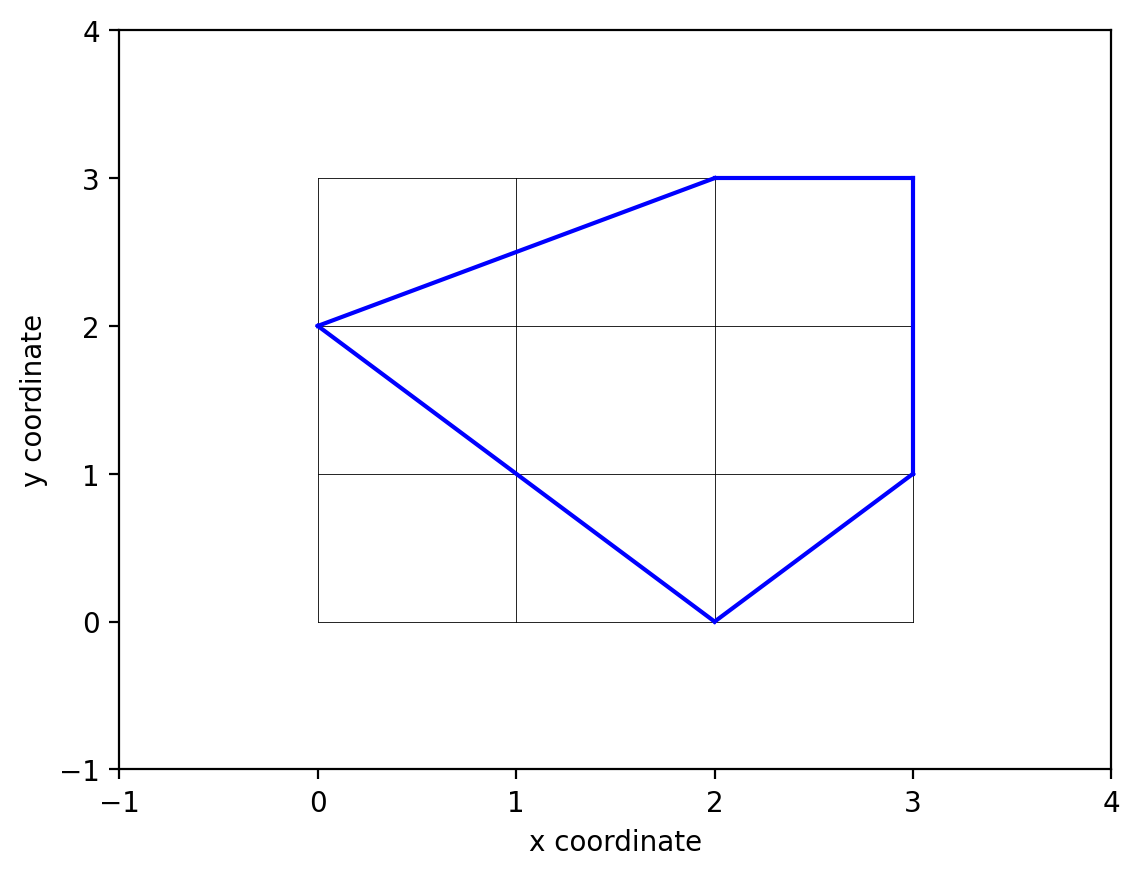

In [ ]:
# Pre-condition:
# - 'np' (NumPy) and 'plt' (Matplotlib's Pyplot) must be imported
# - 'draw_board' function should be defined
# - 'pcPolygon' class should be defined with 'initialize' and 'draw' methods

# Post-condition:
# - Creates a polygon instance with the given vertices
# - Initializes the polygon with vertices defined in 'list_vertex'
# - Draws the coordinate system and the polygon on the grid using Matplotlib

# Create a polygon with specified vertices
list_vertex = [np.array((2, 0)), np.array((3, 1)), np.array((3, 3)),
               np.array((2, 3)), np.array((0, 2))]  # List of vertices for the polygon
new_polygon = pcPolygon()  # Initialize a new polygon instance
new_polygon.initialize(list_vertex)  # Initialize the polygon with the list of vertices

# Draw the problem setup
draw_board()  # Draw the grid or coordinate system
new_polygon.draw()  # Draw the polygon on the grid




In [ ]:
# Pre-condition:
# - NumPy (np) and PennyLane (qml) must be imported
# - 'is_in_polygon' function should be defined
# - 'new_polygon' instance should be initialized with vertices
# - 'qml.device' must be set with appropriate backend and number of wires

# Post-condition:
# - Sets up a quantum circuit on the specified device
# - Initializes a quantum node to execute the circuit
# - Defines wires for different parts of the circuit: coordinates, auxiliary, and summing
# - The circuit checks if a given point (a, b) is inside the polygon

# Create the quantum device
n = 3  # Number of qubits for representing x and y coordinates
m = int(np.ceil(np.log2(new_polygon.nVertex)))  # Number of qubits needed to sum the results
nWireCount = 2*n + (2*n + 3) + m  # Total number of wires needed

# Define the quantum device with the specified number of wires
dev = qml.device("lightning.qubit", wires = nWireCount, shots = 1)
@qml.qnode(dev)
def circuit(a, b, polygon, wires_a, wires_b, wires_aux, wires_sum):
    # Embed the point (a, b) into the quantum circuit
    qml.BasisEmbedding(a, wires = wires_a)
    qml.BasisEmbedding(b, wires = wires_b)

    # Call the function to check if the point is inside the polygon
    is_in_polygon(polygon, wires_a, wires_b, wires_aux, wires_sum)
    return qml.sample()

# Set wires for different parts of the circuit
wires_a = list(range(0, n))          # Wires for x-coordinates
wires_b = list(range(n, 2*n))        # Wires for y-coordinates
wires_aux = list(range(2*n, 2*n + (2*n + 3)))  # Auxiliary wires
wires_sum = list(range(2*n + (2*n + 3), 2*n + (2*n + 3) + m))  # Wires for summing results



Time taken to execute the oracle: 16.40455412864685 seconds
The point ( 1 , 0 ) NO belongs to the polygon
Time taken to execute the oracle: 10.58214259147644 seconds
The point ( 2 , 1 ) YES belongs to the polygon


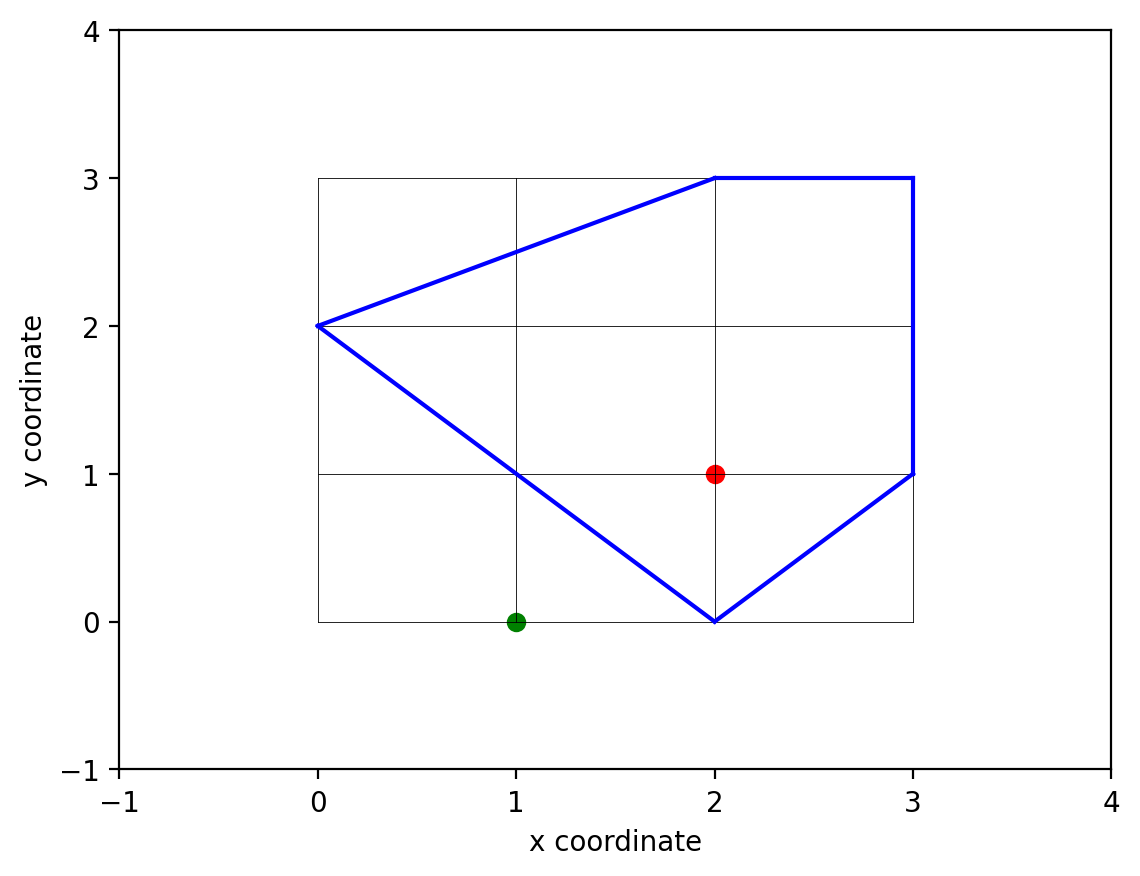

In [ ]:
# Pre-condition:
# - 'circuit' function must be defined
# - 'binary_to_integer' function should be defined
# - 'new_polygon' instance should be initialized with vertices
# - Matplotlib (plt) must be imported
# - 'draw_board' function should be defined

# Post-condition:
# - Executes the quantum circuit for two different points
# - Determines if each point belongs inside the polygon
# - Prints the execution time for each oracle call
# - Plots the points on a graph with appropriate colors based on their inclusion in the polygon
# - Draws the polygon on the board


import time

# Example 1: Check if point (1, 0) is inside the polygon
start_time = time.time()  # Start timer
a, b = 1, 0  # Define point coordinates
sol = circuit(a, b, new_polygon, wires_a, wires_b, wires_aux, wires_sum)  # Execute the circuit
print("Time taken to execute the oracle:", time.time() - start_time, "seconds")  # Display execution time
sol_str = "YES" if binary_to_integer(sol[wires_sum]) == 0 else "NO"  # Interpret the result
print("The point (", a, ",", b, ")", sol_str, "belongs to the polygon")  # Display result
color_point = "red" if binary_to_integer(sol[wires_sum]) == 0 else "green"  # Choose color based on result
plt.scatter(a, b, color = color_point)  # Plot the point

# Example 2: Check if point (2, 1) is inside the polygon
start_time = time.time()  # Start timer
a, b = 2, 1  # Define point coordinates
sol = circuit(a, b, new_polygon, wires_a, wires_b, wires_aux, wires_sum)  # Execute the circuit
print("Time taken to execute the oracle:", time.time() - start_time, "seconds")  # Display execution time
sol_str = "YES" if binary_to_integer(sol[wires_sum]) == 0 else "NO"  # Interpret the result
print("The point (", a, ",", b, ")", sol_str, "belongs to the polygon")  # Display result
color_point = "red" if binary_to_integer(sol[wires_sum]) == 0 else "green"  # Choose color based on result
plt.scatter(a, b, color = color_point)  # Plot the point

# Draw the polygon
draw_board()  # Draw the board
new_polygon.draw()  # Draw the polygon



## Several polygons

In [ ]:
# Pre-condition:
# - 'is_in_polygon' function must be defined
# - Quantum Machine Learning library (qml) must be imported
# - 'polygon_list' must be a list of initialized polygon objects
# - 'wires_x', 'wires_y', 'wires_aux_origin', and 'wires_res' must be defined as quantum wires


# Post-condition:
# - Executes the 'is_in_polygon' function for each polygon in the list
# - Sets 'wires_res' to 1 if the point is outside all polygons in the list


def is_in_polygon_list(polygon_list, wires_x, wires_y, wires_aux_origin, wires_res):
    '''
    Determines if a point, represented by quantum wires 'wires_x' and 'wires_y',
    is inside any of the polygons in 'polygon_list'. Sets 'wires_res' to 1 if the point
    is outside all polygons.

    Args:
        polygon_list: List of polygon objects to check
        wires_x: Quantum wires representing the x-coordinate of the point
        wires_y: Quantum wires representing the y-coordinate of the point
        wires_aux_origin: Auxiliary quantum wires for computation
        wires_res: Quantum wire to store the result (1 if point is outside all polygons)

    Returns:
        None: Alters 'wires_res' to reflect whether the point is outside all polygons
    '''

    # Check if there are enough ancillary qubits
    max_vertex = max(polygon.nVertex for polygon in polygon_list)
    m = int(np.ceil(np.log2(max_vertex)))

    # Return if there are not enough qubits
    if len(wires_aux_origin) < (2 * len(wires_x) + 3) + m:
        print("Not enough ancillary qubits")
        return

    # Set wires for summing and auxiliary operations
    wires_sum = wires_aux_origin[:m]
    wires_aux = wires_aux_origin[m:]

    # Check if the point is inside any polygon in the list
    for polygon in polygon_list:
        is_in_polygon(polygon, wires_x, wires_y, wires_aux, wires_sum)
        vStringCombo = ''.join(str(0) for j in range(len(wires_sum)))
        qml.MultiControlledX(control_wires=wires_sum, wires=wires_res[0], control_values=vStringCombo)
        qml.adjoint(is_in_polygon)(polygon, wires_x, wires_y, wires_aux, wires_sum)

    # Invert the result
    qml.PauliX(wires=wires_res[0])


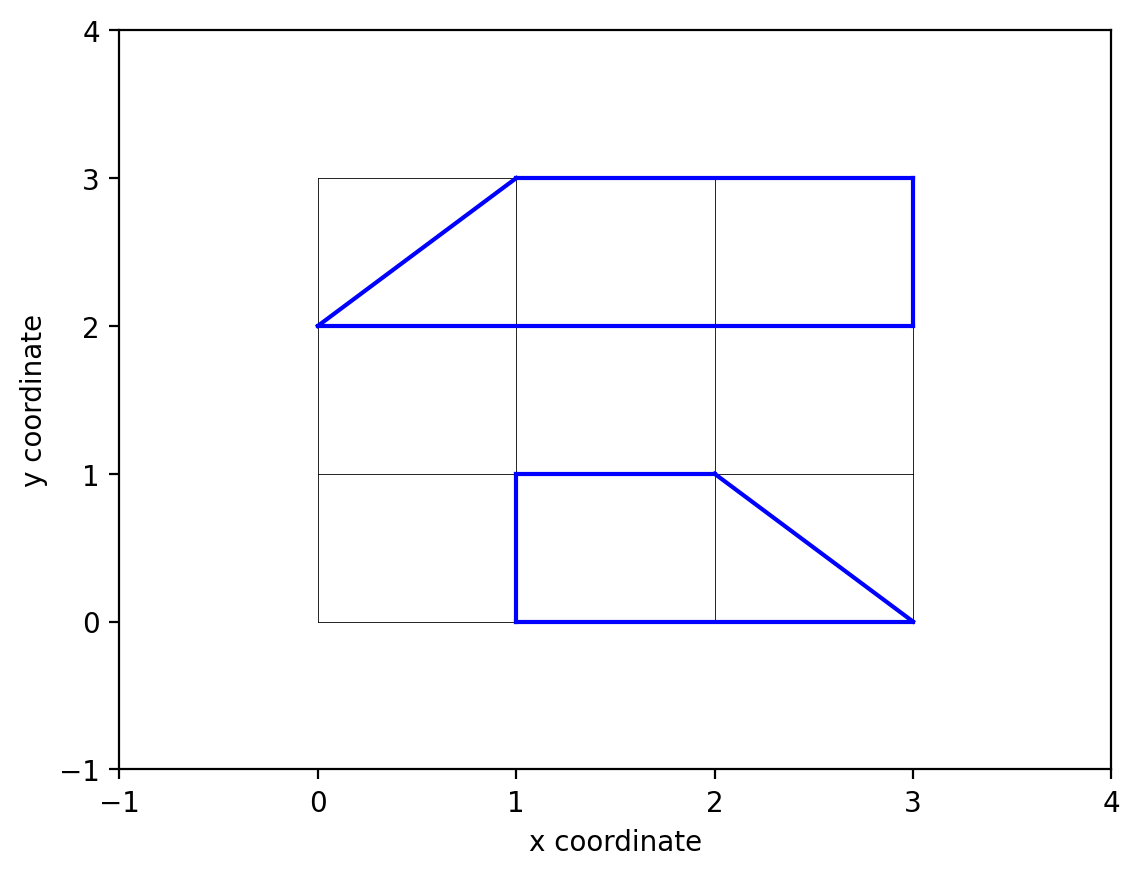

In [ ]:
# Pre-condition:
# - The 'pcPolygon' class and 'draw_board' function must be defined
# - The 'np' module from NumPy library must be imported

# Post-condition:
# - Two polygons are defined, initialized, and added to 'polygon_list'
# - The polygons are drawn on the board using their 'draw' method


# Create a list to store polygons
polygon_list = list()

# Define the first polygon and add it to the list
# The first polygon is defined by four vertices
list_vertex = [np.array((0, 2)), np.array((3, 2)), np.array((3, 3)), np.array((1, 3))]
new_polygon = pcPolygon()  # Create a new polygon instance
new_polygon.initialize(list_vertex)  # Initialize the polygon with the list of vertices
polygon_list.append(new_polygon)  # Add the polygon to the list

# Define the second polygon and add it to the list
# The second polygon is defined by four vertices
list_vertex = [np.array((1, 0)), np.array((3, 0)), np.array((2, 1)), np.array((1, 1))]
new_polygon = pcPolygon()  # Create another new polygon instance
new_polygon.initialize(list_vertex)  # Initialize the polygon with the list of vertices
polygon_list.append(new_polygon)  # Add the polygon to the list

# Draw the problem setup
draw_board()  # Draw the grid or board
for polygon in polygon_list:
    polygon.draw()  # Draw each polygon in the list


In [ ]:
# Pre-condition:
# - The 'qml' module from PennyLane must be imported
# - The 'is_in_polygon_list' function must be defined
# - The 'polygon_list' should be initialized with polygons
# - The 'np' module from NumPy library must be imported

# Post-condition:
# - A quantum circuit is created to check if a point (a, b) is inside any polygon in the polygon list
# - The circuit uses qubits for x and y coordinates, auxiliary qubits, and a result qubit
# - The circuit's output can be sampled to get the result


# Set the number of qubits for x and y coordinates
n = 3

## Get the m value
wire_aux_origin = list(range(2*n, 2*n + (2*n + 3) + m))


# Determine the maximum number of vertices in the polygons
max_vertex = 0
for polygon in polygon_list:
    max_vertex = max(max_vertex, polygon.nVertex)
m = int(np.ceil(np.log2(max_vertex)))  # Calculate the number of qubits needed for the sum operation

# Define the qubit wires
wires_a = list(range(0, n))  # Qubits for x coordinate
wires_b = list(range(n, 2*n))  # Qubits for y coordinate
wires_aux_origin = list(range(2*n, 2*n + (2*n + 3) + m))  # Auxiliary qubits
wires_res = [wire_aux_origin[-1] + 1]  # Result qubit
nTotalWires = wires_res[0] + 1  # Total number of qubits

# Define the quantum device
dev = qml.device("lightning.qubit", wires=nTotalWires, shots=1)
@qml.qnode(dev)
def circuit(a, b, polygon_list, wires_a, wires_b, wires_aux, wires_res):
    # Set the input point
    qml.BasisEmbedding(a, wires=wires_a)
    qml.BasisEmbedding(b, wires=wires_b)

    # Call the function to check if the point is in any polygon
    is_in_polygon_list(polygon_list, wires_a, wires_b, wires_aux, wires_res)
    return qml.sample()


The point (0, 1) NO belongs to the polygon
Time taken to execute the oracle: 51.38609075546265 seconds
The point (1, 2) YES belongs to the polygon
Time taken to execute the oracle: 39.01356053352356 seconds
The point (3, 1) NO belongs to the polygon
Time taken to execute the oracle: 38.4772469997406 seconds


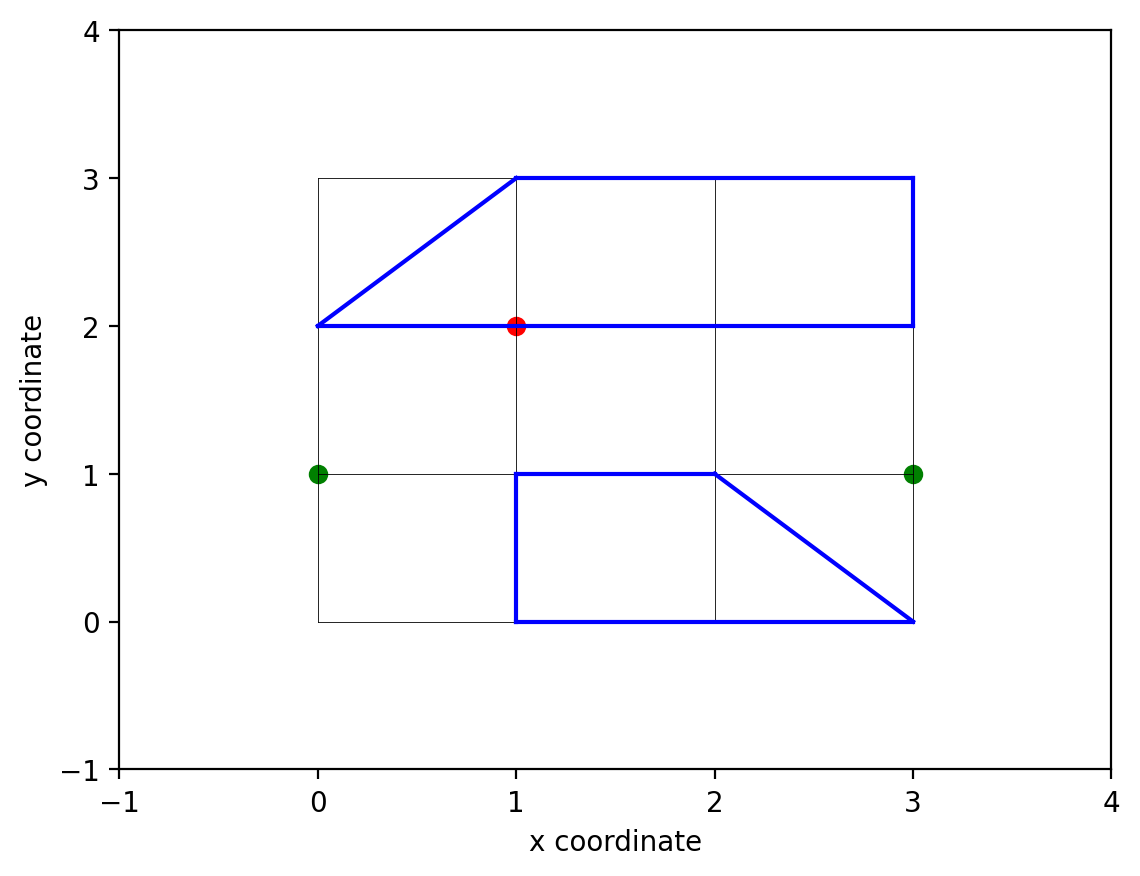

In [ ]:
# Pre-condition:
# - The 'circuit' function must be defined and set up correctly
# - The 'binary_to_integer' function must be defined for converting binary to integer
# - The 'plt' module from matplotlib must be imported for plotting
# - The 'polygon_list' should be initialized with polygons
# - The 'draw_board' function should be defined to draw the grid
# - The 'time' module must be imported to measure execution time

# Post-condition:
# - The results for each point (a, b) will be displayed, indicating whether each point is inside the polygon
# - The points will be plotted on a grid, with their color indicating their status (inside or outside the polygon)
# - The execution time for each oracle call is displayed


# Example 1: Check if the point (0, 1) is in the polygon
start_time = time.time()
a, b = 0, 1
solution = circuit(a, b, polygon_list, wires_a, wires_b, wire_aux_origin, wires_res)
solution_str = "YES" if binary_to_integer(solution[wires_res]) == 0 else "NO"
print(f"The point ({a}, {b}) {solution_str} belongs to the polygon")
print("Time taken to execute the oracle:", time.time() - start_time, "seconds")
color_point = "red" if binary_to_integer(solution[wires_res]) == 0 else "green"
plt.scatter(a, b, color=color_point)

# Example 2: Check if the point (1, 2) is in the polygon
start_time = time.time()
a, b = 1, 2
solution = circuit(a, b, polygon_list, wires_a, wires_b, wire_aux_origin, wires_res)
solution_str = "YES" if binary_to_integer(solution[wires_res]) == 0 else "NO"
print(f"The point ({a}, {b}) {solution_str} belongs to the polygon")
print("Time taken to execute the oracle:", time.time() - start_time, "seconds")
color_point = "red" if binary_to_integer(solution[wires_res]) == 0 else "green"
plt.scatter(a, b, color=color_point)

# Example 3: Check if the point (3, 1) is in the polygon
start_time = time.time()
a, b = 3, 1
solution = circuit(a, b, polygon_list, wires_a, wires_b, wire_aux_origin, wires_res)
solution_str = "YES" if binary_to_integer(solution[wires_res]) == 0 else "NO"
print(f"The point ({a}, {b}) {solution_str} belongs to the polygon")
print("Time taken to execute the oracle:", time.time() - start_time, "seconds")
color_point = "red" if binary_to_integer(solution[wires_res]) == 0 else "green"
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.scatter(a, b, color=color_point)

# Draw the problem setup
draw_board()
for polygon in polygon_list:
    polygon.draw()



## Grover's algorithm
Once we have built the previous functions, we can build Grover's algorithm

In [ ]:
## Disfusor operator
def DifusorOperator(wires_x, wires_y, wires_aux):
    ## Set the wires_aux
    qml.PauliX(wires = wires_aux[0])
    qml.Hadamard(wires = wires_aux[0])

    ## Difusor phase
    apply_hadamard(wires_x)
    apply_hadamard(wires_y)

    wires_join = wires_x + wires_y
    vStringCombo = ''.join(str(0) for j in range(len(wires_join)))
    qml.MultiControlledX(control_wires = wires_join, wires = wires_aux[0], control_values = vStringCombo)
    qml.QubitUnitary(-np.eye(2), wires = wires_x[1])

    apply_hadamard(wires_x)
    apply_hadamard(wires_y)

    ## Restore the qubit auxiliar
    qml.Hadamard(wires = wires_aux[0])
    qml.PauliX(wires = wires_aux[0])
    return

We define a quantum circuit to check that everything is correct.

In [ ]:
# Pre-condition:
# - The 'apply_hadamard', 'is_in_polygon_list', and 'DifusorOperator' functions must be defined
# - The 'qml' module from PennyLane must be imported and set up
# - The 'polygon_list' should be initialized with polygons

# Post-condition:
# - The 'circuit' function is ready to be used to check if points are in the specified polygons
# - The 'list_points' list is initialized to store points evaluated by the circuit
# - The quantum device 'dev' is set up with the appropriate number of wires and shots


# Set wires for the quantum circuit
wires_a = list(range(0, n))
wires_b = list(range(n, 2*n))
wire_aux_origin = list(range(2*n, 2*n + (2*n + 3) + m))
wires_res = [wire_aux_origin[-1] + 1]
nTotalWires = wires_res[0] + 1

# Define the quantum device
dev = qml.device("default.qubit", wires=nTotalWires, shots=1)

@qml.qnode(dev)
def circuit(polygon_list, wires_x, wires_y, wires_aux_origin, wires_res):
    # Set the superposition state for the input qubits
    apply_hadamard(wires_x[1:])
    apply_hadamard(wires_y[1:])

    # Apply the Grover iterator
    qml.PauliX(wires=wires_res[0])
    qml.Hadamard(wires=wires_res[0])
    is_in_polygon_list(polygon_list, wires_x, wires_y, wires_aux_origin, wires_res)
    qml.Hadamard(wires=wires_res[0])
    qml.PauliX(wires=wires_res[0])
    DifusorOperator(wires_x[1:], wires_y[1:], wires_aux_origin)
    return qml.sample()

# Set auxiliary wires for the computation
wires_aux = list(range(2*n, 2*n + (2*n + 3)))
wires_sum = list(range(2*n + (2*n + 3), 2*n + (2*n + 3) + m))

# Initialize a list to store the points
list_points = list()

In [ ]:
# Pre-condition:
# - The 'circuit' function and 'binary_to_integer' utility must be defined and ready to use
# - The 'polygon_list' should be populated with polygons
# - The 'wires_a', 'wires_b', and 'wires_res' arrays should be set up for the quantum circuit
# - The 'time' module must be imported for tracking execution time

# Post-condition:
# - The point evaluated by the quantum circuit is printed and added to 'list_points'
# - The execution time for the oracle is displayed


# Start time tracking
start_time = time.time()

# Execute the quantum circuit
solution = circuit(polygon_list, wires_a, wires_b, wire_aux_origin, wires_res)

# Convert binary qubit states to integer values for point coordinates
solution_point = np.array((binary_to_integer(solution[wires_a]), binary_to_integer(solution[wires_b])))
print("The point is at (", solution_point[0], ",", solution_point[1], ")")

# Append the solution point to the list of points
list_points.append(solution_point)

# Print the execution time of the oracle
print("Time taken to execute the oracle was:", time.time() - start_time, "seconds")



The point is at ( 0 , 3 )
Time taken to execute the oracle was: 51.49953293800354 seconds


In [ ]:
# Pre-condition:
# - The 'circuit' function, 'binary_to_integer' utility, and 'time' module must be defined and ready to use
# - The 'polygon_list' should be populated with polygons
# - The 'wires_a', 'wires_b', and 'wires_res' arrays should be set up for the quantum circuit
# - The number of points to evaluate (nPoints) should be defined

# Post-condition:
# - Executes the quantum circuit 'nPoints' times, each time printing the coordinates of the evaluated point and the execution time
# - All evaluated points are added to 'list_points'


# Initialize the list to store points
nPoints = 10
list_points = []

# Loop through the specified number of points
for i in range(nPoints):
    # Start time tracking for each iteration
    start_time = time.time()

    # Execute the quantum circuit and get the solution
    solution = circuit(polygon_list, wires_a, wires_b, wire_aux_origin, wires_res)

    # Convert binary qubit states to integer values for point coordinates
    solution_point = np.array((binary_to_integer(solution[wires_a]), binary_to_integer(solution[wires_b])))
    print("The point is at (", solution_point[0], ",", solution_point[1], ")")

    # Append the solution point to the list of points
    list_points.append(solution_point)

    # Print the execution time of the oracle for each point
    print("Time taken to execute the oracle was:", time.time() - start_time, "seconds")

The point is at ( 0 , 1 )
Time taken to execute the oracle was: 55.64759111404419 seconds
The point is at ( 0 , 1 )
Time taken to execute the oracle was: 54.25627851486206 seconds
The point is at ( 0 , 1 )
Time taken to execute the oracle was: 55.204444885253906 seconds
The point is at ( 0 , 1 )
Time taken to execute the oracle was: 54.582637786865234 seconds
The point is at ( 0 , 3 )
Time taken to execute the oracle was: 53.36874270439148 seconds
The point is at ( 0 , 3 )
Time taken to execute the oracle was: 51.31550431251526 seconds
The point is at ( 3 , 1 )
Time taken to execute the oracle was: 52.874751329422 seconds
The point is at ( 0 , 1 )
Time taken to execute the oracle was: 51.59132409095764 seconds
The point is at ( 3 , 1 )
Time taken to execute the oracle was: 51.16220259666443 seconds
The point is at ( 3 , 1 )
Time taken to execute the oracle was: 52.774937868118286 seconds


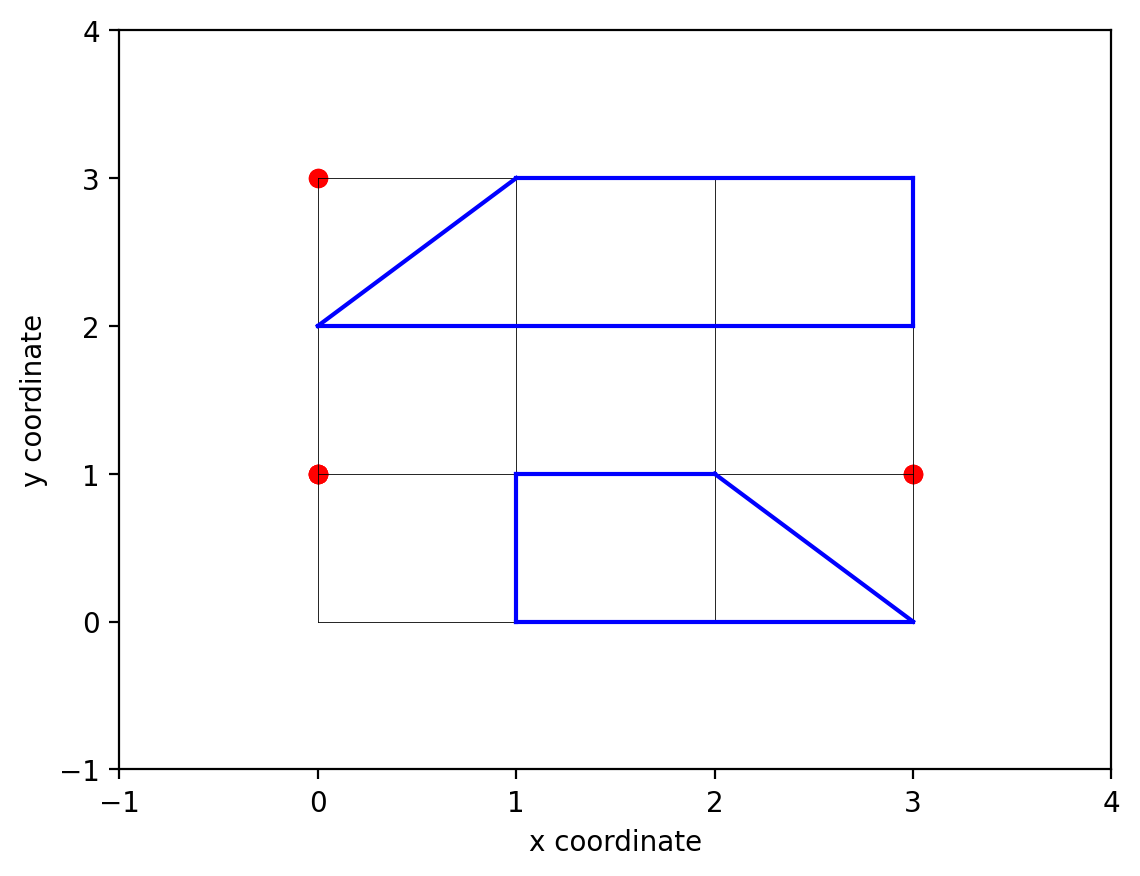

In [ ]:
# Pre-condition:
# - The 'draw_board', 'draw_points', and 'polygon.draw' functions must be defined and ready to use
# - The 'polygon_list' should contain the list of polygons to be drawn
# - The 'list_points' should contain the list of points to be plotted
# Post-condition:
# - The computational grid is drawn with polygons and points plotted according to their respective positions

# Function to draw the computational problem on the board
def draw_problem():
    # Draw the grid or board where the problem is set
    draw_board()

    # Loop through each polygon in the polygon list and draw them
    for polygon in polygon_list:
        polygon.draw()

    # Draw the points calculated in the quantum circuit
    draw_points(list_points)

# Execute the function to draw the problem
draw_problem()



Cite this work:
